## Atuação de redes neurais na base de dados do ENEM.

##### Alunos:

-   Gabriel Fonseca (2111066)
-   Yasmim Santos (2116925)
-   Alejandro Elias (2111189)
-   Pedro Lucas (2111131)

Base de dados escolhida - Exame Nacional do Ensino Médio (Enem): https://basedosdados.org/dataset/3e9c8804-c31c-4f48-9a45-d67f1c21a859


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

### Preparando os dados para utilização no modelo (Redimensionamento, Encodificação e Agrupamento)


In [2]:
df_enem = pd.read_csv(
    f"../data/out/enem-dados-tratados.csv",
    dtype={
        "id_inscricao": np.int64,
        "ensino": int,
        "nota_ciencias_natureza": float,
        "nota_ciencias_humanas": float,
        "nota_linguagens_codigos": float,
        "nota_matematica": float,
        "nota_redacao": float,
        "q_formacao_pai": str,
        "q_formacao_mae": str,
        "q_renda_familia": str,
    },
)

colunas_red = [
    "nota_ciencias_natureza",
    "nota_ciencias_humanas",
    "nota_linguagens_codigos",
    "nota_matematica",
    "nota_redacao",
]

colunas_red_norm = [
    "cn_norm",
    "ch_norm",
    "lc_norm",
    "ma_norm",
    "nr_norm",
]

mm_scaler = MinMaxScaler()
df_enem[colunas_red_norm] = mm_scaler.fit_transform(df_enem[colunas_red])

for col, col_norm in zip(colunas_red, colunas_red_norm):
    df_enem = df_enem[df_enem[col] != 0.0]
    df_enem = df_enem[df_enem[col_norm] != 0.0]

colunas_para_encodificar = [
    "ensino",
    "q_formacao_pai",
    "q_formacao_mae",
    "q_renda_familia",
]

dummies = pd.get_dummies(
    df_enem[colunas_para_encodificar], drop_first=True, dtype=np.int64
)
df_enem = pd.concat([df_enem, dummies], axis=1)

df_enem = df_enem.drop(
    columns=[
        "id_inscricao",
        "ensino",
        "nota_ciencias_natureza",
        "nota_ciencias_humanas",
        "nota_linguagens_codigos",
        "nota_matematica",
        "nota_redacao",
        "q_formacao_pai",
        "q_formacao_mae",
        "q_renda_familia",
        "ano",
    ]
)

df_enem.dropna(inplace=True)
df_enem.reset_index(drop=True, inplace=True)

kmeans_r_state = 43
pca_r_state = 59

df_enem

,cn_norm,ch_norm,lc_norm,ma_norm,nr_norm,q_formacao_pai_B,q_formacao_pai_C,q_formacao_pai_D,q_formacao_pai_E,q_formacao_pai_F,...,q_renda_familia_H,q_renda_familia_I,q_renda_familia_J,q_renda_familia_K,q_renda_familia_L,q_renda_familia_M,q_renda_familia_N,q_renda_familia_O,q_renda_familia_P,q_renda_familia_Q
0,0.420980,0.506492,0.465539,0.333736,0.38,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.587628,0.738349,0.686738,0.553072,0.76,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.540342,0.602017,0.578751,0.353273,0.58,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.565362,0.743334,0.688231,0.654079,0.84,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.543211,0.618363,0.551505,0.450554,0.40,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.458051,0.353698,0.349216,0.372004,0.16,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
176575,0.836681,0.829121,0.869370,0.861631,0.98,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
176576,0.715024,0.773012,0.802812,0.829305,0.98,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
176577,0.569953,0.465917,0.439662,0.425579,0.28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Observando os intervalos de possíveis números de componentes e selecionando um


In [4]:
pca = PCA(random_state=pca_r_state)
pca.fit(df_enem.to_numpy())
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

n_components = np.argmax(exp_var_cumul >= 0.8) + 1

# Se você só botar um número decimal entre 0 e 1
# o PCA automaticamente determinar o número de
# componentes que explicam a variância explicada almejada
exp_variance_almejada = 0.8

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"},
    title=f"Variação explicada por cada componente (Nº componente escolhida: {n_components})",
)

In [6]:
components_columns = ["pc" + str(i) for i in range(1, n_components + 1)]

pca = PCA(n_components=exp_variance_almejada, random_state=pca_r_state)
components = pca.fit_transform(df_enem.to_numpy())
df_new = pd.DataFrame(data=components, columns=components_columns)
df_new.columns = components_columns
df_new.dropna(inplace=True)

df_new

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
0,0.080772,-0.762073,0.785344,-0.199763,-0.054474,0.049956,0.085050,-0.540186,0.122072,-0.009362,-0.204898,0.117835,0.051410
1,-0.393375,-0.548348,0.338719,0.221931,0.016531,-0.173464,-0.307263,-0.246616,-0.040627,-0.236042,0.013228,0.149151,-0.062164
2,0.776151,0.015068,-0.138434,-0.401179,-0.118830,0.141522,0.238751,-0.504722,0.119801,-0.021895,-0.216883,0.090682,0.061713
3,-0.298046,-0.212125,-0.284790,0.008430,-0.069643,-0.025388,0.005119,0.034026,-0.003387,0.037279,0.015956,-0.047916,-0.000200
4,-0.112868,-0.191350,-0.089860,0.090640,-0.013206,-0.043427,0.032071,0.104094,0.030599,0.156165,0.022743,-0.053975,0.017265
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.690036,0.275459,-0.179738,0.192363,0.070071,-0.119768,-0.097107,-0.064469,0.026961,-0.002592,0.017000,0.109585,-0.016937
176575,-0.864842,0.316885,-0.248852,-0.297564,-0.790837,-0.036312,-0.041148,-0.010111,0.254087,-0.300741,-0.073473,-0.255974,-0.679935
176576,-0.690970,-0.464786,-0.921494,-0.172441,-0.288681,-0.029161,-0.171940,-0.371105,-0.857430,0.223314,-0.043965,0.255782,0.331875
176577,-0.095767,-0.509821,0.567618,0.561371,0.035605,-0.666054,-0.746404,-0.182828,0.341725,0.691652,-0.216274,-0.045458,0.064502


### Descobrindo o melhor valor de K (Qtd. de Clusters) com base no método do cotovelo


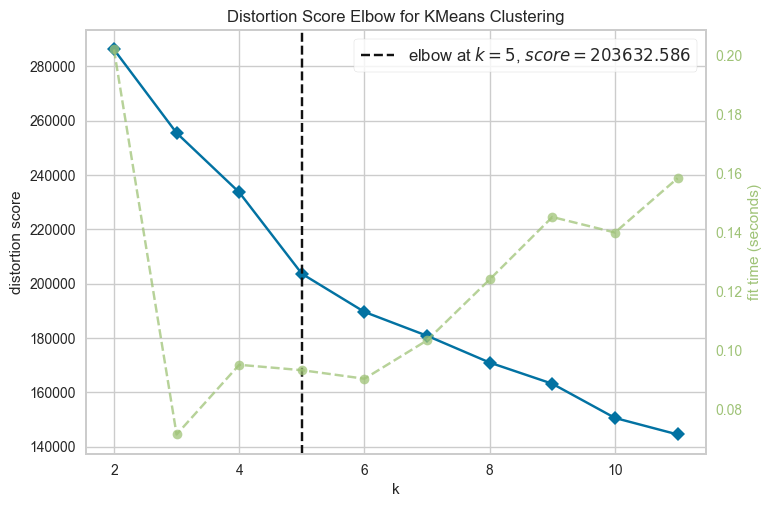

In [7]:
model = KMeans(random_state=kmeans_r_state)
visualizer = KElbowVisualizer(model, k=(2, 12))

X_kmeans = df_new.to_numpy()

visualizer.fit(X_kmeans)

k = visualizer.elbow_value_

_ = visualizer.show()

### Descobrindo o número de componentes com a melhor silhueta.


In [102]:
df_sis = pd.DataFrame(
    columns=["n_components", "silhouette_score"],
)

for i in range(2, 20):
    n_components_teste = i
    components_columns_teste = ["pc" + str(i) for i in range(1, n_components_teste + 1)]

    pca = PCA(n_components=n_components_teste, random_state=pca_r_state)
    components_teste = pca.fit_transform(df_enem.to_numpy())
    df_new_teste = pd.DataFrame(data=components_teste, columns=components_columns_teste)
    df_new_teste.columns = components_columns_teste
    df_new_teste.dropna(inplace=True)

    X_kmeans_teste = df_new_teste.to_numpy()

    kmeans_teste = KMeans(n_clusters=k, random_state=kmeans_r_state)
    kmeans_teste.fit(X_kmeans_teste)

    sil_score = silhouette_score(
        X_kmeans_teste,
        kmeans_teste.labels_,
        metric="euclidean",
        sample_size=50000,
    )

    df_sis.loc[len(df_sis)] = [n_components_teste, sil_score]

# convert n_components column to int
df_sis["n_components"] = df_sis["n_components"].astype(int)
n_components = df_sis.loc[df_sis["silhouette_score"].idxmax()]["n_components"]

df_sis.sort_values(by="silhouette_score", inplace=True, ascending=False)
df_sis

,n_components,silhouette_score
0,2,0.503366
1,3,0.464662
2,4,0.401464
3,5,0.350788
4,6,0.313534
5,7,0.277441
6,8,0.257700
7,9,0.247142
9,11,0.225049
10,12,0.211377


### Preparando o conjunto de dados com o número de componentes escolhido


In [8]:
n_components = 13 # int(n_components)

components_columns = ["pc" + str(i) for i in range(1, n_components + 1)]

pca = PCA(n_components=n_components, random_state=pca_r_state)
components = pca.fit_transform(df_enem.to_numpy())

df_new = pd.DataFrame(data=components, columns=components_columns)
df_new.columns = components_columns
df_new.dropna(inplace=True)

total_var = pca.explained_variance_ratio_.sum()
print(f"Total Variance: {total_var:.2%}")

df_new

Total Variance: 80.54%


,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13
0,0.080772,-0.762073,0.785344,-0.199764,-0.054483,0.049965,0.085057,-0.540182,0.122058,-0.009384,-0.204944,0.117868,0.051204
1,-0.393375,-0.548347,0.338718,0.221928,0.016524,-0.173460,-0.307259,-0.246581,-0.040625,-0.236048,0.013179,0.149297,-0.062338
2,0.776151,0.015068,-0.138433,-0.401180,-0.118839,0.141531,0.238757,-0.504716,0.119788,-0.021916,-0.216930,0.090747,0.061515
3,-0.298045,-0.212122,-0.284790,0.008414,-0.069669,-0.025346,0.005120,0.034136,-0.003425,0.037167,0.015733,-0.047331,-0.001086
4,-0.112868,-0.191347,-0.089860,0.090623,-0.013232,-0.043385,0.032071,0.104206,0.030562,0.156052,0.022517,-0.053376,0.016360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.690036,0.275459,-0.179739,0.192360,0.070063,-0.119760,-0.097103,-0.064441,0.026953,-0.002614,0.016944,0.109682,-0.017169
176575,-0.864843,0.316883,-0.248853,-0.297550,-0.790818,-0.036361,-0.041141,-0.010166,0.254156,-0.300570,-0.073253,-0.256313,-0.678971
176576,-0.690970,-0.464787,-0.921498,-0.172432,-0.288687,-0.029190,-0.171915,-0.371058,-0.857355,0.223508,-0.043842,0.255755,0.332502
176577,-0.095767,-0.509823,0.567619,0.561381,0.035622,-0.666075,-0.746409,-0.182901,0.341742,0.691724,-0.216121,-0.045788,0.065079


### Rotulando os dados com base no agrupamento realizado


In [9]:
X_kmeans = df_new.to_numpy()

kmeans = KMeans(n_clusters=k, random_state=kmeans_r_state)
kmeans.fit(X_kmeans)

df_new["label"] = kmeans.labels_
df_new.to_csv(f"../data/out/enem-dados-tratados-ml.csv", index=False)

df_new

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,label
0,0.080772,-0.762073,0.785344,-0.199764,-0.054483,0.049965,0.085057,-0.540182,0.122058,-0.009384,-0.204944,0.117868,0.051204,0
1,-0.393375,-0.548347,0.338718,0.221928,0.016524,-0.173460,-0.307259,-0.246581,-0.040625,-0.236048,0.013179,0.149297,-0.062338,3
2,0.776151,0.015068,-0.138433,-0.401180,-0.118839,0.141531,0.238757,-0.504716,0.119788,-0.021916,-0.216930,0.090747,0.061515,2
3,-0.298045,-0.212122,-0.284790,0.008414,-0.069669,-0.025346,0.005120,0.034136,-0.003425,0.037167,0.015733,-0.047331,-0.001086,4
4,-0.112868,-0.191347,-0.089860,0.090623,-0.013232,-0.043385,0.032071,0.104206,0.030562,0.156052,0.022517,-0.053376,0.016360,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176574,0.690036,0.275459,-0.179739,0.192360,0.070063,-0.119760,-0.097103,-0.064441,0.026953,-0.002614,0.016944,0.109682,-0.017169,2
176575,-0.864843,0.316883,-0.248853,-0.297550,-0.790818,-0.036361,-0.041141,-0.010166,0.254156,-0.300570,-0.073253,-0.256313,-0.678971,1
176576,-0.690970,-0.464787,-0.921498,-0.172432,-0.288687,-0.029190,-0.171915,-0.371058,-0.857355,0.223508,-0.043842,0.255755,0.332502,4
176577,-0.095767,-0.509823,0.567619,0.561381,0.035622,-0.666075,-0.746409,-0.182901,0.341742,0.691724,-0.216121,-0.045788,0.065079,3
